In [2]:
import sgkit as sg
import pandas as pd
import numpy as np
import zarr
import xarray as xr
import allel

In [161]:
import sgkit as sg

ds = sg.load_dataset('/Users/christinagkertsou/Desktop/Finalyearproject/dataset/AgamP4_2L.zarr')
ds

<xarray.Dataset>
Dimensions:               (variants: 1855171, samples: 18, alleles: 4,
                           ploidy: 2, alt_alleles: 3)
Dimensions without coordinates: variants, samples, alleles, ploidy, alt_alleles
Data variables: (12/15)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 18, 4), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 18), meta=np.ndarray>
    ...                    ...
    variant_MQ            (variants) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_allele        (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig        (variants) int8 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  4
    source:                sgkit-0.4.0

In [162]:
G = ds['call_genotype']
G

<xarray.DataArray 'call_genotype' (variants: 1855171, samples: 18, ploidy: 2)>
dask.array<open_dataset-e27a01d500eb9794b11bd6d692c86a04call_genotype, shape=(1855171, 18, 2), dtype=int8, chunksize=(10000, 18, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: variants, samples, ploidy
Attributes:
    comment:       Call genotype. Encoded as allele values (0 for the referen...
    mixed_ploidy:  False

In [163]:
ds['sample_id'].compute()

<xarray.DataArray 'sample_id' (samples: 18)>
array(['ara_wt_054', 'ara_wt_055', 'gam_wt_01', 'gam_wt_10', 'gam_wt_02',
       'gam_wt_03', 'gam_wt_04', 'gam_wt_05', 'gam_wt_06', 'gam_wt_07',
       'gam_wt_08', 'gam_wt_09', 'hyb_C10', 'hyb_E10', 'hyb_E14',
       'hyb_E16', 'hyb_E25', 'hyb_E28'], dtype=object)
Dimensions without coordinates: samples
Attributes:
    comment:  The unique identifier of the sample.

In [165]:
ds['sample_cohort'] = xr.DataArray([0] * 2 + [1] * 10 + [2] * 6, dims="samples")
ds['sample_cohort_name'] = xr.DataArray(['ara'] * 2 + ['gam'] * 10 + ['hyb_ctr'] + ['hyb'] * 5, dims="samples")
ds['sample_cohort_name']

<xarray.DataArray 'sample_cohort_name' (samples: 18)>
array(['ara', 'ara', 'gam', 'gam', 'gam', 'gam', 'gam', 'gam', 'gam',
       'gam', 'gam', 'gam', 'hyb_ctr', 'hyb', 'hyb', 'hyb', 'hyb', 'hyb'],
      dtype='<U7')
Dimensions without coordinates: samples

In [166]:
g = allel.GenotypeArray(G.compute())
g

<GenotypeArray shape=(1855171, 18, 2) dtype=int8>
./. ./. 0/1 0/1 0/0 ... ./. ./. ./. ./. ./.
./. ./. 0/0 0/0 0/0 ... ./. ./. ./. ./. ./.
./. ./. 0/0 0/0 0/0 ... ./. ./. ./. ./. ./.
...
1/1 1/1 ./. ./. ./. ... ./. ./. ./. ./. ./.
1/1 1/1 ./. ./. ./. ... ./. ./. ./. ./. ./.
1/1 1/1 ./. ./. ./. ... ./. ./. ./. ./. ./.

In [167]:
ds['sample_cohort'] = xr.DataArray([0] * 2 + [1] * 10 + [2] * 6, dims="samples")
ds['sample_cohort_name'] = xr.DataArray(['ara'] * 2 + ['gam'] * 10 + ['hyb_ctr'] + ['hyb'] * 5, dims="samples")
ds['sample_cohort_name']

sample_is_hyb = ds['sample_cohort_name'] == 'hyb'
sample_is_ara = ds['sample_cohort_name'] == 'ara'
sample_is_gam = ds['sample_cohort_name'] == 'gam'

In [168]:
g[:,sample_is_ara,:].is_called()

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [9]:
# original array is filtered to contain only ARA samples (edo)
g_ara = g[:,sample_is_ara,:]

# we make a mask to select only variants that are called in both ara samples
mask_g_ara_is_called = g_ara.is_called().all(axis=1)

# we apply mask to ARA samples to keep only variants called in both samples
g_ara_called = g_ara[mask_g_ara_is_called,:,:]
g_ara_called

<GenotypeArray shape=(1231544, 2, 2) dtype=int8>
0/0 1/1
0/0 1/1
0/1 0/1
...
1/1 1/1
1/1 1/1
1/1 1/1

In [10]:
# create position index
pos = allel.SortedIndex(ds['variant_position'])

# select only positions that are called in ara
pos_ara_called = pos[mask_g_ara_is_called]
pos_ara_called

0,1,2,3,4,...,1231539,1231540,1231541,1231542,1231543
3894,3913,4235,4260,7580,...,49359034,49359061,49359453,49359464,49359493


In [11]:
# count the numper of positions in a given range
len(pos_ara_called[pos_ara_called.locate_range(1, 150_000)])

501

In [12]:
with open("/Users/christinagkertsou/Desktop/Finalyearproject/AgamP4.sizes", 'r') as f:
    sizes = f.readlines()


sizes_dict = {}

for size in sizes:
    chrom, lenght = size.split()

    sizes_dict[chrom] = int(lenght)

sizes_dict

{'AgamP4_2L': 49364325,
 'AgamP4_2R': 61545105,
 'AgamP4_3L': 41963435,
 'AgamP4_3R': 53200684,
 'AgamP4_UNKN': 42389979,
 'AgamP4_X': 24393108,
 'AgamP4_Y_unplaced': 237045,
 'AgamP4_Mt': 15363}

In [54]:
window_limits = np.arange(1, sizes_dict['AgamP4_2L'], 150_000)

windows = []

for i in range(0, len(window_limits), 1):
    windows.append((window_limits[i-1], window_limits[i]))

windows

[(49350001, 1),
 (1, 150001),
 (150001, 300001),
 (300001, 450001),
 (450001, 600001),
 (600001, 750001),
 (750001, 900001),
 (900001, 1050001),
 (1050001, 1200001),
 (1200001, 1350001),
 (1350001, 1500001),
 (1500001, 1650001),
 (1650001, 1800001),
 (1800001, 1950001),
 (1950001, 2100001),
 (2100001, 2250001),
 (2250001, 2400001),
 (2400001, 2550001),
 (2550001, 2700001),
 (2700001, 2850001),
 (2850001, 3000001),
 (3000001, 3150001),
 (3150001, 3300001),
 (3300001, 3450001),
 (3450001, 3600001),
 (3600001, 3750001),
 (3750001, 3900001),
 (3900001, 4050001),
 (4050001, 4200001),
 (4200001, 4350001),
 (4350001, 4500001),
 (4500001, 4650001),
 (4650001, 4800001),
 (4800001, 4950001),
 (4950001, 5100001),
 (5100001, 5250001),
 (5250001, 5400001),
 (5400001, 5550001),
 (5550001, 5700001),
 (5700001, 5850001),
 (5850001, 6000001),
 (6000001, 6150001),
 (6150001, 6300001),
 (6300001, 6450001),
 (6450001, 6600001),
 (6600001, 6750001),
 (6750001, 6900001),
 (6900001, 7050001),
 (7050001, 7200

In [52]:
window_limits

array([       1,   150001,   300001,   450001,   600001,   750001,
         900001,  1050001,  1200001,  1350001,  1500001,  1650001,
        1800001,  1950001,  2100001,  2250001,  2400001,  2550001,
        2700001,  2850001,  3000001,  3150001,  3300001,  3450001,
        3600001,  3750001,  3900001,  4050001,  4200001,  4350001,
        4500001,  4650001,  4800001,  4950001,  5100001,  5250001,
        5400001,  5550001,  5700001,  5850001,  6000001,  6150001,
        6300001,  6450001,  6600001,  6750001,  6900001,  7050001,
        7200001,  7350001,  7500001,  7650001,  7800001,  7950001,
        8100001,  8250001,  8400001,  8550001,  8700001,  8850001,
        9000001,  9150001,  9300001,  9450001,  9600001,  9750001,
        9900001, 10050001, 10200001, 10350001, 10500001, 10650001,
       10800001, 10950001, 11100001, 11250001, 11400001, 11550001,
       11700001, 11850001, 12000001, 12150001, 12300001, 12450001,
       12600001, 12750001, 12900001, 13050001, 13200001, 13350

In [40]:
#windows & finding centres
midpoints = []

numpoints=[]
    
for window in windows[1:]:
    lower_limit = int(window[0])
    upper_limit = int(window[1])
    #length and not pslice, then normal
    x = len(pos_ara_called[pos_ara_called.locate_range(lower_limit, upper_limit)])
    numpoints.append(x)
# print(len(x['variant_position']))
    mid=(lower_limit+upper_limit)/2
    midpoints.append(mid)

In [42]:
numpointscom=[i/150_000 for i in numpoints]
print(numpoints)

[501, 696, 1067, 593, 611, 782, 980, 669, 805, 578, 1251, 1060, 944, 1528, 888, 923, 1044, 1459, 1480, 1240, 1442, 1519, 1663, 2273, 2102, 2229, 1714, 2123, 2441, 1735, 2080, 2087, 1852, 1472, 673, 988, 1661, 2723, 2559, 2264, 2648, 2213, 2060, 2580, 3304, 2946, 2809, 2455, 2185, 1230, 2160, 2608, 2477, 3106, 1688, 1833, 848, 2529, 2392, 2599, 2200, 2594, 3376, 3723, 3037, 3459, 3872, 3463, 2828, 4096, 3967, 3888, 3948, 3500, 4253, 4112, 3414, 4142, 4659, 3599, 3271, 2929, 3217, 3097, 3151, 4552, 3220, 4077, 3248, 1964, 3870, 3424, 2881, 4040, 4517, 3932, 3729, 3438, 3056, 3427, 3519, 2951, 3268, 3455, 3580, 3297, 3865, 2283, 3244, 3665, 3432, 3556, 3343, 2580, 2904, 3246, 3889, 3855, 3739, 3332, 2547, 3675, 3191, 3020, 3555, 4182, 3245, 2985, 3896, 3746, 3726, 3900, 3998, 3550, 3492, 3453, 3188, 4102, 3909, 5391, 5596, 5367, 6398, 5953, 5788, 5728, 5685, 5783, 6124, 5788, 4777, 4779, 5789, 6000, 5375, 5335, 5349, 5003, 5257, 4851, 5096, 5073, 4938, 4748, 4478, 5022, 4510, 5488, 4631, 

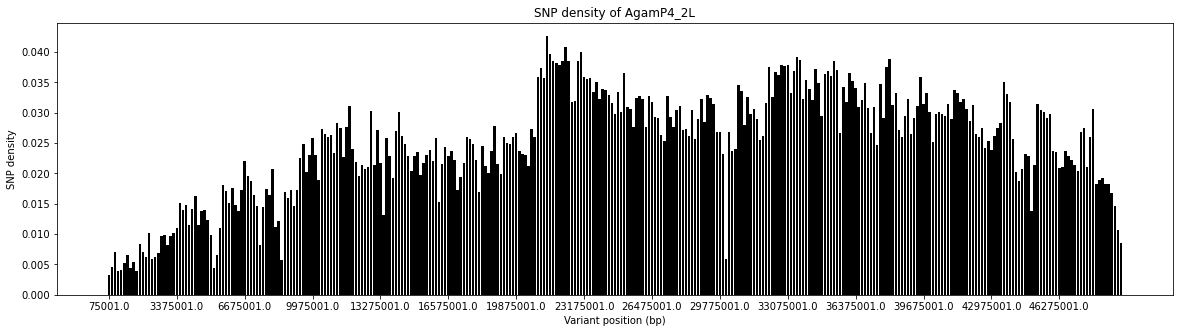

In [55]:
import matplotlib.pyplot as plt

import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 5))

plot_2Ln=sns.barplot(x=midpoints, y=numpointscom, ax=ax, color="black")
ax.locator_params(axis="x", tight=None, nbins=15)
plot_2Ln.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=("SNP density of AgamP4_2L"))


fig.savefig('Ara_AgamP4_2Ln.pdf', dpi=300)

In [ ]:
import sgkit as sg
import pandas as pd
import numpy as np
import zarr
import xarray as xr
import allel

ds = sg.load_dataset('/Users/christinagkertsou/Desktop/Finalyearproject/dataset/AgamP4_2L.zarr')
ds

G = ds['call_genotype']
G

ds['sample_id'].compute()

ds['sample_cohort'] = xr.DataArray([0] * 2 + [1] * 10 + [2] * 6, dims="samples")
ds['sample_cohort_name'] = xr.DataArray(['ara'] * 2 + ['gam'] * 10 + ['hyb_ctr'] + ['hyb'] * 5, dims="samples")
ds['sample_cohort_name']

g = allel.GenotypeArray(G.compute())
g

sample_is_hyb = ds['sample_cohort_name'] == 'hyb'
sample_is_ara = ds['sample_cohort_name'] == 'ara'
sample_is_gam = ds['sample_cohort_name'] == 'gam'

# create position index
pos = allel.SortedIndex(ds['variant_position'])

# select only positions that are called in ara
pos_ara_called = pos[mask_g_ara_is_called]
pos_ara_called

In [91]:
# STARTS HERE
# plot_snp_density(ds, 'AgamP4_2L', sizes_dict, name_figure)
#this part different from the next function:     result_dict['numpoints_ara'] = midpoints
                                                #result_dict['numpoints_gam'] = midpoints
                                                #result_dict['numpoints_hyb'] = midpoints, should probably be:     
                                                #result_dict['numpoints_ara'] = numpoints_ara
                                                #result_dict['numpoints_gam'] = numpoints_gam
                                                #result_dict['numpoints_hyb'] = numpoints_hyb


def plot_snp_density(ds, contig_name, sizes_dict, path_figure, window_size=150_000):

    G = ds['call_genotype']
    G

    ds['sample_id'].compute()

    ds['sample_cohort'] = xr.DataArray([0] * 2 + [1] * 10 + [2] * 6, dims="samples")
    ds['sample_cohort_name'] = xr.DataArray(['ara'] * 2 + ['gam'] * 10 + ['hyb_ctr'] + ['hyb'] * 5, dims="samples")
    ds['sample_cohort_name']

    g = allel.GenotypeArray(G.compute())
    g

    sample_is_hyb = ds['sample_cohort_name'] == 'hyb'
    sample_is_ara = ds['sample_cohort_name'] == 'ara'
    sample_is_gam = ds['sample_cohort_name'] == 'gam'

    # create position index
    pos = allel.SortedIndex(ds['variant_position'])


    # original array is filtered to contain only ARA samples
    g_ara = g[:,sample_is_ara,:]
    g_gam = g[:,sample_is_gam,:]
    g_hyb = g[:,sample_is_hyb,:]

    # we make a mask to select only variants that are called in both ara samples
    mask_g_ara_is_called = g_ara.is_called().all(axis=1)
    mask_g_gam_is_called = g_gam.is_called().all(axis=1)
    mask_g_hyb_is_called = g_hyb.is_called().all(axis=1)

    # we apply mask to ARA samples to keep only variants called in both samples
    g_ara_called = g_ara[mask_g_ara_is_called,:,:]
    g_ara_called
    g_gam_called = g_gam[mask_g_gam_is_called,:,:]
    g_gam_called
    g_hyb_called = g_hyb[mask_g_hyb_is_called,:,:]
    g_hyb_called

    # select only positions that are called in ara
    pos_ara_called = pos[mask_g_ara_is_called]
    pos_ara_called
    pos_gam_called = pos[mask_g_gam_is_called]
    pos_gam_called
    pos_hyb_called = pos[mask_g_hyb_is_called]
    pos_hyb_called

    # create windows
    window_limits = np.arange(1, sizes_dict[contig_name], window_size)

    windows = []

    for i in range(0, len(window_limits), 1):
        windows.append((window_limits[i-1], window_limits[i]))

    windows

    #windows & finding centres


    midpoints = []

    numpoints_ara=[]
    numpoints_gam=[]
    numpoints_hyb=[]
    result_dict = {}
    for window in windows[1:]:
        lower_limit = int(window[0])
        upper_limit = int(window[1])
        x_ara = len(pos_ara_called[pos_ara_called.locate_range(lower_limit, upper_limit)])
        numpoints_ara.append(x_ara)
        x_gam = len(pos_gam_called[pos_gam_called.locate_range(lower_limit, upper_limit)])
        numpoints_gam.append(x_gam)
        try:
            x_hyb = len(pos_hyb_called[pos_hyb_called.locate_range(lower_limit, upper_limit)])
        except:
            x_hyb = 0
        numpoints_hyb.append(x_hyb)
    # print(len(x['variant_position']))
        mid=(lower_limit+upper_limit)/2
        midpoints.append(mid)


    result_dict['midpoints'] = midpoints
    result_dict['numpoints_ara'] = midpoints
    result_dict['numpoints_gam'] = midpoints
    result_dict['numpoints_hyb'] = midpoints

    numpointscom=[i/150_000 for i in numpoints]

    return result_dict

    # plotting

    fig, ax = plt.subplots(figsize=(20, 5))

    plot_cont=sns.lineplot(x=midpoints, y=numpoints_ara, ax=ax, label="Arabiensis")
    plot_cont=sns.lineplot(x=midpoints, y=numpoints_hyb, ax=ax, label="Hybrids")
    plot_cont=sns.lineplot(x=midpoints, y=numpoints_gam, ax=ax, label="Gambiae")
    plot_cont.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=(f"SNP density of {contig_name}"))

    plt.show()


    fig.savefig(f'{path_figure}/SNP_density_{contig_name}.pdf', dpi=300) 

    return None

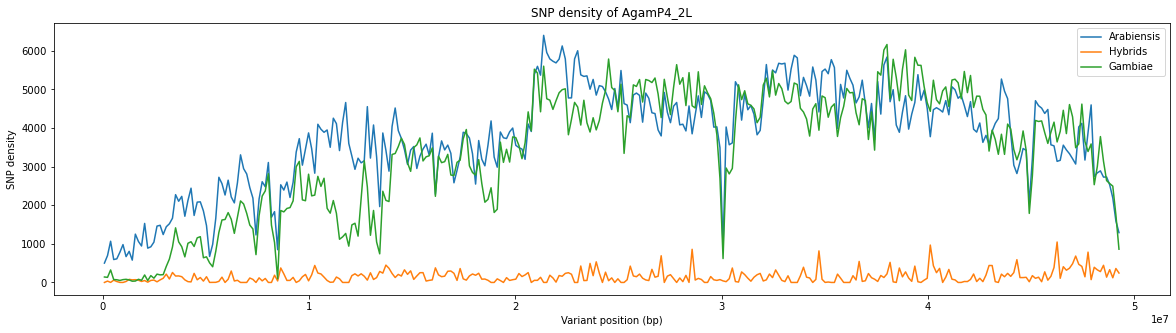

In [92]:
result_dict_2L = plot_snp_density(ds, "AgamP4_2L",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

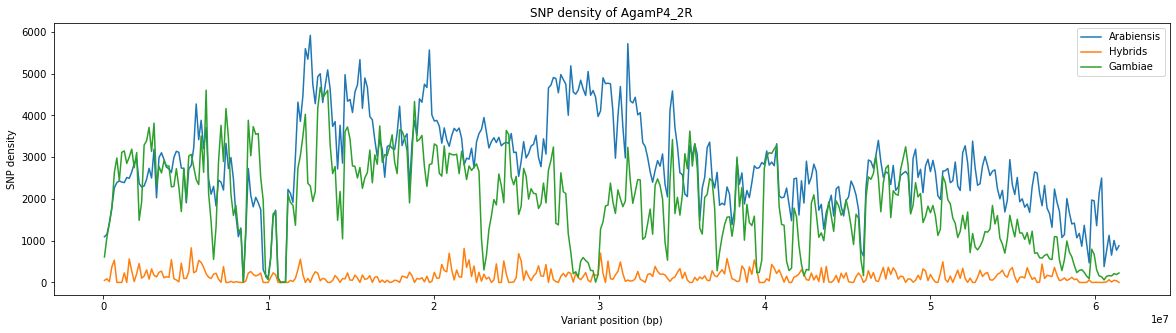

In [93]:
ds1 = sg.load_dataset('/Users/christinagkertsou/Desktop/Finalyearproject/dataset/AgamP4_2R.zarr')
ds1

plot_snp_density(ds1, "AgamP4_2R",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)


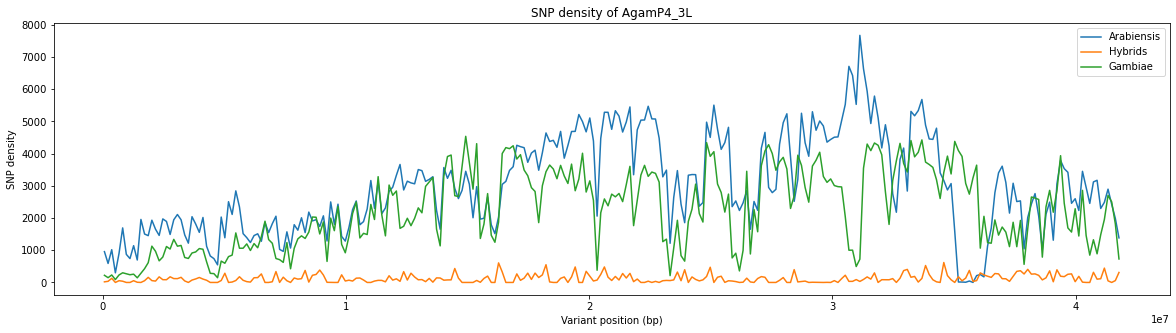

In [94]:
ds2 = sg.load_dataset('/Users/christinagkertsou/Desktop/Finalyearroject/dataset/AgamP4_3L.zarr')
ds2
plot_snp_density(ds2, "AgamP4_3L",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

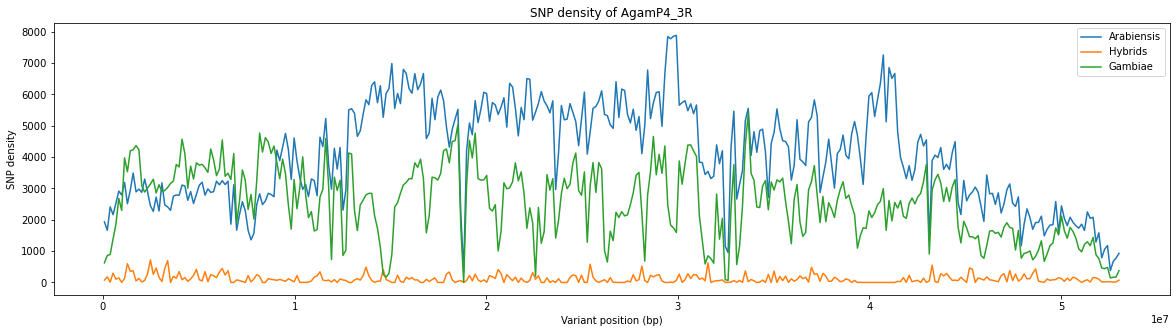

In [95]:
ds3 = sg.load_dataset('/Users/christinagkertsou/Desktop/Finalyearproject/dataset/AgamP4_3R.zarr')
ds3
plot_snp_density(ds3, "AgamP4_3R",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

In [114]:
# STARTS HERE
# plot_snp_density(ds, 'AgamP4_2L', sizes_dict, name_figure)


def plot_snp_density(ds, contig_name, sizes_dict, path_figure, window_size=150_000):

    G = ds['call_genotype']
    G

    ds['sample_id'].compute()

    ds['sample_cohort'] = xr.DataArray([0] * 2 + [1] * 10 + [2] * 6, dims="samples")
    ds['sample_cohort_name'] = xr.DataArray(['ara'] * 2 + ['gam'] * 10 + ['hyb_ctr'] + ['hyb'] * 5, dims="samples")
    ds['sample_cohort_name']

    g = allel.GenotypeArray(G.compute())
    g

    sample_is_hyb = ds['sample_cohort_name'] == 'hyb'
    sample_is_ara = ds['sample_cohort_name'] == 'ara'
    sample_is_gam = ds['sample_cohort_name'] == 'gam'

    # create position index
    pos = allel.SortedIndex(ds['variant_position'])


    # original array is filtered to contain only ARA samples
    g_ara = g[:,sample_is_ara,:]
    g_gam = g[:,sample_is_gam,:]
    g_hyb = g[:,sample_is_hyb,:]

    # we make a mask to select only variants that are called in both ara samples
    mask_g_ara_is_called = g_ara.is_called().all(axis=1)
    mask_g_gam_is_called = g_gam.is_called().all(axis=1)
    mask_g_hyb_is_called = g_hyb.is_called().all(axis=1)

    # we apply mask to ARA samples to keep only variants called in both samples
    g_ara_called = g_ara[mask_g_ara_is_called,:,:]
    g_ara_called
    g_gam_called = g_gam[mask_g_gam_is_called,:,:]
    g_gam_called
    g_hyb_called = g_hyb[mask_g_hyb_is_called,:,:]
    g_hyb_called

    # select only positions that are called in ara
    pos_ara_called = pos[mask_g_ara_is_called]
    pos_ara_called
    pos_gam_called = pos[mask_g_gam_is_called]
    pos_gam_called
    pos_hyb_called = pos[mask_g_hyb_is_called]
    pos_hyb_called

    # create windows
    window_limits = np.arange(1, sizes_dict[contig_name], window_size)

    windows = []

    for i in range(0, len(window_limits), 1):
        windows.append((window_limits[i-1], window_limits[i]))

    windows

    #windows & finding centres


    midpoints = []

    numpoints_ara=[]
    numpoints_gam=[]
    numpoints_hyb=[]
    result_dict = {}
    for window in windows[1:]:
        lower_limit = int(window[0])
        upper_limit = int(window[1])
        x_ara = len(pos_ara_called[pos_ara_called.locate_range(lower_limit, upper_limit)])
        numpoints_ara.append(x_ara)
        x_gam = len(pos_gam_called[pos_gam_called.locate_range(lower_limit, upper_limit)])
        numpoints_gam.append(x_gam)
        try:
            x_hyb = len(pos_hyb_called[pos_hyb_called.locate_range(lower_limit, upper_limit)])
        except:
            x_hyb = 0
        numpoints_hyb.append(x_hyb)
    # print(len(x['variant_position']))
        mid=(lower_limit+upper_limit)/2
        midpoints.append(mid)


    result_dict['midpoints'] = midpoints
    result_dict['numpoints_ara'] = numpoints_ara
    result_dict['numpoints_gam'] = numpoints_gam
    result_dict['numpoints_hyb'] = numpoints_hyb

    numpointscom=[i/150_000 for i in numpoints]

    return result_dict

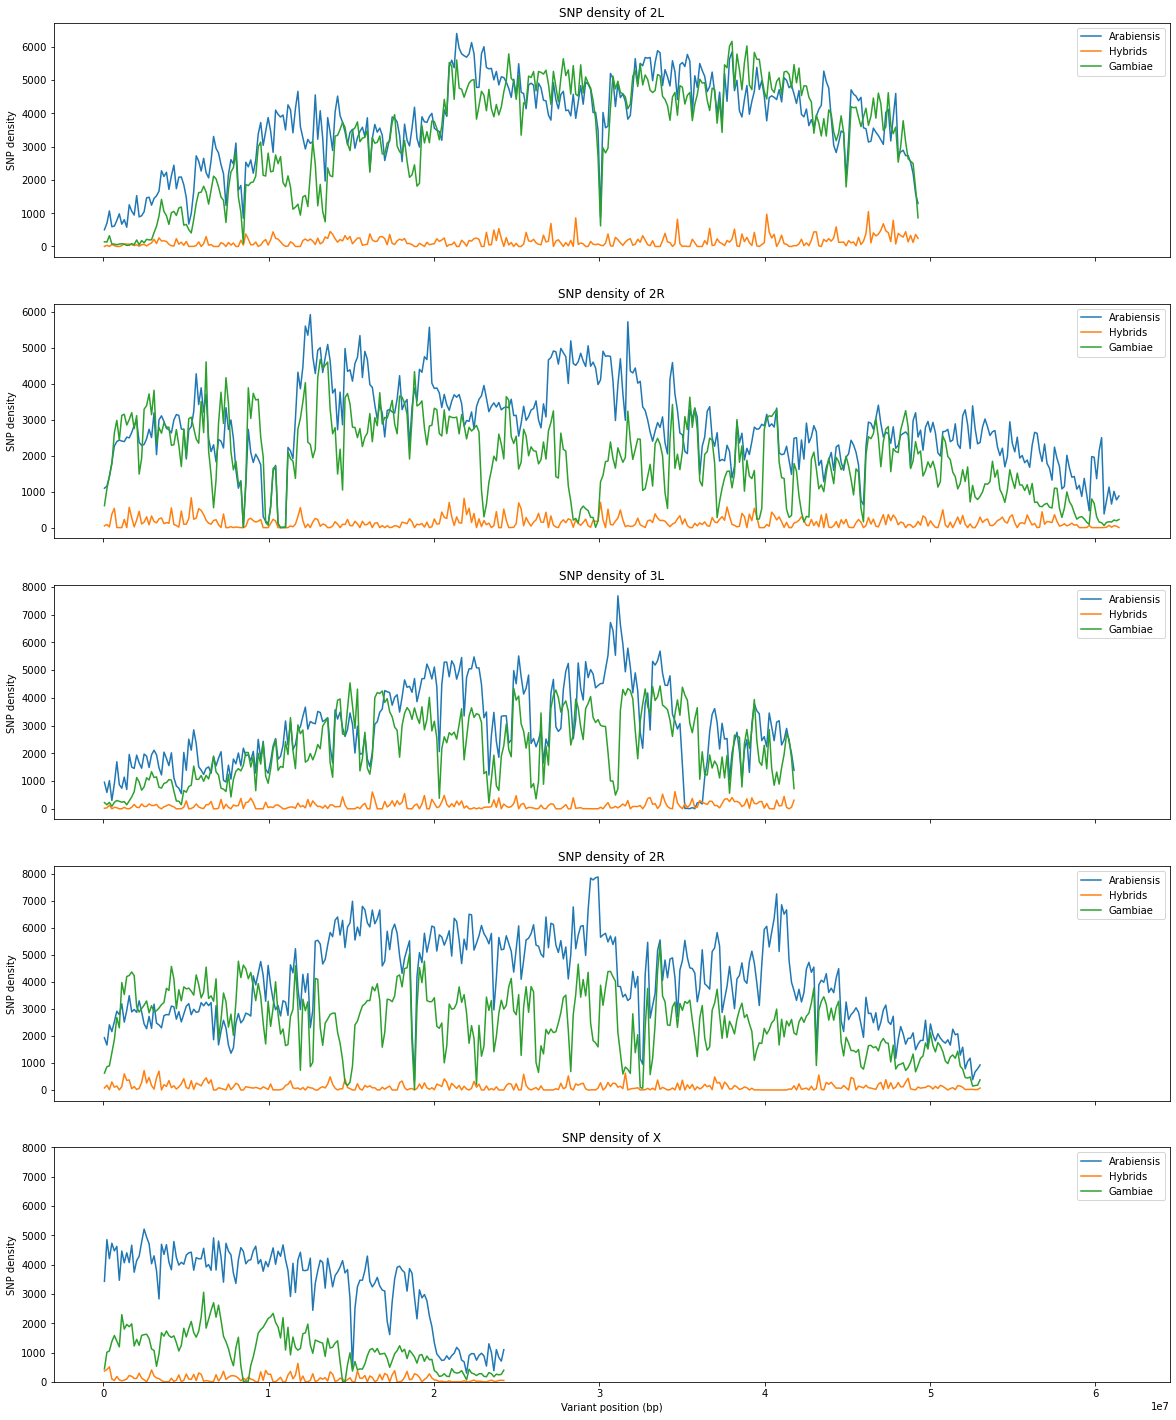

In [158]:
ds = sg.load_dataset('/Users/christinagkertsou/Desktop/Finalyearproject/dataset/AgamP4_2L.zarr')


result_dict_2L = plot_snp_density(ds, "AgamP4_2L",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)


fig, ax = plt.subplots(5, figsize=(20, 25), sharex=True)


plot_cont=sns.lineplot(x=result_dict_2L['midpoints'], y=result_dict_2L['numpoints_ara'], ax=ax[0], label="Arabiensis")
plot_cont=sns.lineplot(x=result_dict_2L['midpoints'], y=result_dict_2L['numpoints_hyb'], ax=ax[0], label="Hybrids")
plot_cont=sns.lineplot(x=result_dict_2L['midpoints'], y=result_dict_2L['numpoints_gam'], ax=ax[0], label="Gambiae")
plot_cont.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=(f"SNP density of 2L"))

result_dict_2R = plot_snp_density(ds1, "AgamP4_2R",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_2R['midpoints'], y=result_dict_2R['numpoints_ara'], ax=ax[1], label="Arabiensis")
plot_cont=sns.lineplot(x=result_dict_2R['midpoints'], y=result_dict_2R['numpoints_hyb'], ax=ax[1], label="Hybrids")
plot_cont=sns.lineplot(x=result_dict_2R['midpoints'], y=result_dict_2R['numpoints_gam'], ax=ax[1], label="Gambiae")
plot_cont.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=(f"SNP density of 2R"))

result_dict_3L = plot_snp_density(ds2, "AgamP4_3L",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_3L['midpoints'], y=result_dict_3L['numpoints_ara'], ax=ax[2], label="Arabiensis")
plot_cont=sns.lineplot(x=result_dict_3L['midpoints'], y=result_dict_3L['numpoints_hyb'], ax=ax[2], label="Hybrids")
plot_cont=sns.lineplot(x=result_dict_3L['midpoints'], y=result_dict_3L['numpoints_gam'], ax=ax[2], label="Gambiae")
plot_cont.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=(f"SNP density of 3L"))

result_dict_3R = plot_snp_density(ds3, "AgamP4_3R",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_3R['midpoints'], y=result_dict_3R['numpoints_ara'], ax=ax[3], label="Arabiensis")
plot_cont=sns.lineplot(x=result_dict_3R['midpoints'], y=result_dict_3R['numpoints_hyb'], ax=ax[3], label="Hybrids")
plot_cont=sns.lineplot(x=result_dict_3R['midpoints'], y=result_dict_3R['numpoints_gam'], ax=ax[3], label="Gambiae")
plot_cont.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=(f"SNP density of 2R"))

result_dict_X = plot_snp_density(ds5, "AgamP4_X",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_X['midpoints'], y=result_dict_X['numpoints_ara'], ax=ax[4], label="Arabiensis")
plot_cont=sns.lineplot(x=result_dict_X['midpoints'], y=result_dict_X['numpoints_hyb'], ax=ax[4], label="Hybrids")
plot_cont=sns.lineplot(x=result_dict_X['midpoints'], y=result_dict_X['numpoints_gam'], ax=ax[4], label="Gambiae")
plot_cont.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=(f"SNP density of X"))


plt.ylim(0, 8000)
plt.show()





# fig.savefig(f'{path_figure}/SNP_density_{contig_name}.pdf', dpi=300) 

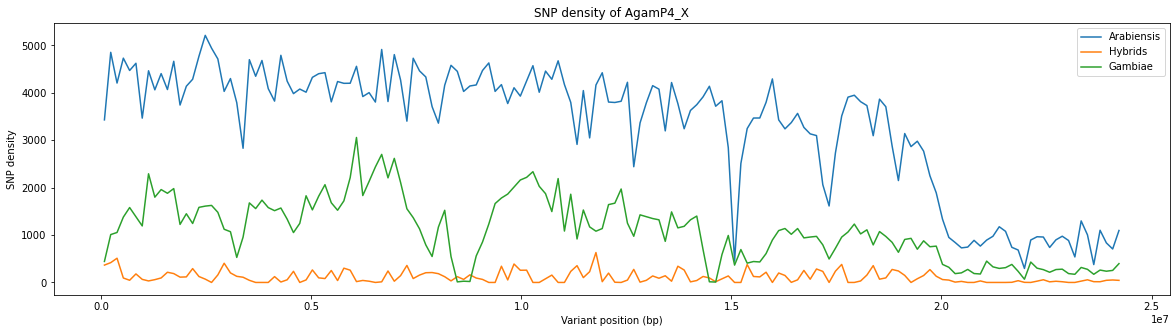

In [97]:
ds5 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_X.zarr')
ds5
plot_snp_density(ds5, "AgamP4_X",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

In [169]:
#Looking at fixed hom alt. allele (Ara)

# original array is filtered to contain only ARA samples
g_ara = g[:,sample_is_ara,:]

# we make a mask to select only variants that are called in both ara samples
mask_g_ara_is_called = g_ara.is_called().all(axis=1)

# we apply mask to ARA samples to keep only variants called in both samples
g_ara_called = g_ara[mask_g_ara_is_called,:,:]
g_ara_called


<GenotypeArray shape=(1231544, 2, 2) dtype=int8>
0/0 1/1
0/0 1/1
0/1 0/1
...
1/1 1/1
1/1 1/1
1/1 1/1

In [171]:
is_fixed_ara_test=g[:,sample_is_ara].is_hom_alt().all(axis=1)


In [172]:
# markers
is_fixed_ara_test

array([False, False, False, ...,  True,  True,  True])

In [201]:
g_markers = g[is_fixed_ara_test,:]
g_markers

pos_markers = pos[is_fixed_ara_test]
pos_markers

0,1,2,3,4,...,977002,977003,977004,977005,977006
9626,9644,9655,10583,10590,...,49358995,49359061,49359453,49359464,49359493


In [193]:
g_markers[:,sample_is_hyb]

<GenotypeArray shape=(977007, 5, 2) dtype=int8>
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.
...
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.

In [214]:
#Looking at fixed hom alt. allele (Hyb)

# original array is filtered to contain only ARA samples
g_hyb_markers = g_markers[:,sample_is_hyb,:]

#put marker from ara
g_hyb_markers

<GenotypeArray shape=(977007, 5, 2) dtype=int8>
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.
...
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.
./. ./. ./. ./. ./.

In [220]:
#hybrids all (=5)
is_het_hyb_test_all = g_hyb_markers.is_het().all(axis=1)
is_het_hyb_test_all.sum()


10

In [221]:
#hybrids >=3
is_het_hyb_test_3 = g_hyb_markers.is_het().sum(axis=1) >= 3
is_het_hyb_test_3.sum()

1329

In [223]:
#hybrids >=4
is_het_hyb_test_4 = g_hyb_markers.is_het().sum(axis=1) >= 4
is_het_hyb_test_4.sum()

288

In [225]:
#hybrids >=2
is_het_hyb_test_2 = g_hyb_markers.is_het().sum(axis=1) >= 2
is_het_hyb_test_2.sum()

2166

In [226]:
ds2 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_2R.zarr')
ds2


<xarray.Dataset>
Dimensions:               (variants: 1648337, samples: 18, alleles: 4,
                           ploidy: 2, alt_alleles: 3)
Dimensions without coordinates: variants, samples, alleles, ploidy, alt_alleles
Data variables: (12/15)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 18, 4), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 18), meta=np.ndarray>
    ...                    ...
    variant_MQ            (variants) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_allele        (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig        (variants) int8 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  4
    source:                sgkit-0.4.0

In [249]:
ds3 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_3L.zarr')
ds3 

<xarray.Dataset>
Dimensions:               (variants: 1175548, samples: 18, alleles: 4,
                           ploidy: 2, alt_alleles: 3)
Dimensions without coordinates: variants, samples, alleles, ploidy, alt_alleles
Data variables: (12/15)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 18, 4), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 18), meta=np.ndarray>
    ...                    ...
    variant_MQ            (variants) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_allele        (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig        (variants) int8 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  4
    source:                sgkit-0.4.0

In [250]:
ds4 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_3R.zarr')
ds4 

<xarray.Dataset>
Dimensions:               (variants: 1976264, samples: 18, alleles: 4,
                           ploidy: 2, alt_alleles: 3)
Dimensions without coordinates: variants, samples, alleles, ploidy, alt_alleles
Data variables: (12/15)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 18, 4), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 18), meta=np.ndarray>
    ...                    ...
    variant_MQ            (variants) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_allele        (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig        (variants) int8 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  4
    source:                sgkit-0.4.0

In [251]:
ds5 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_X.zarr')
ds5 

<xarray.Dataset>
Dimensions:               (variants: 684159, samples: 18, alleles: 4,
                           ploidy: 2, alt_alleles: 3)
Dimensions without coordinates: variants, samples, alleles, ploidy, alt_alleles
Data variables: (12/15)
    call_AD               (variants, samples, alleles) int32 dask.array<chunksize=(10000, 18, 4), meta=np.ndarray>
    call_DP               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_GQ               (variants, samples) int32 dask.array<chunksize=(10000, 18), meta=np.ndarray>
    call_genotype         (variants, samples, ploidy) int8 dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool dask.array<chunksize=(10000, 18, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool dask.array<chunksize=(10000, 18), meta=np.ndarray>
    ...                    ...
    variant_MQ            (variants) float32 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_allele        (variants, alleles) object dask.array<chunksize=(10000, 4), meta=np.ndarray>
    variant_contig        (variants) int8 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id            (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_id_mask       (variants) bool dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position      (variants) int32 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:               ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R...
    max_alt_alleles_seen:  4
    source:                sgkit-0.4.0

In [6]:
def thres_no(ds, thres_number):

    ds['sample_cohort'] = xr.DataArray([0] * 2 + [1] * 10 + [2] * 6, dims="samples")
    ds['sample_cohort_name'] = xr.DataArray(['ara'] * 2 + ['gam'] * 10 + ['hyb_ctr'] + ['hyb'] * 5, dims="samples")
    ds['sample_cohort_name']

    sample_is_hyb = ds['sample_cohort_name'] == 'hyb'
    sample_is_ara = ds['sample_cohort_name'] == 'ara'
    sample_is_gam = ds['sample_cohort_name'] == 'gam'
    
    g = allel.GenotypeArray(ds['call_genotype'])

    is_fixed_ara_test=g[:,sample_is_ara].is_hom_alt().all(axis=1)
    g_markers = g[is_fixed_ara_test,:]

    # original array is filtered to contain only ARA samples
    g_hyb_markers = g_markers[:,sample_is_hyb,:]

    is_het_hyb_test = g_hyb_markers.is_het().sum(axis=1) >= thres_number
    return is_het_hyb_test.sum()


In [7]:
num_snps = {}

for contig in ['AgamP4_2L', 'AgamP4_2R', 'AgamP4_3L', 'AgamP4_3R', 'AgamP4_X']:
    print(contig)
    ds = sg.load_dataset(f'/Users/christinagkertsou/Desktop/Finalyearproject/dataset/{contig}.zarr')
    num_snps[contig] = []
    
    for threshold in [2, 3, 4, 5]:
        print(threshold,)
        n = thres_no(ds, threshold)
        num_snps[contig].append(n)


AgamP4_2L
2
3
4
5
AgamP4_2R
2
3
4
5
AgamP4_3L
2
3
4
5
AgamP4_3R
2
3
4
5
AgamP4_X
2
3
4
5


In [16]:
import pandas as pd

snp_count_df = pd.DataFrame(num_snps).T
snp_count_df.columns = ['thr_2', "thr_3",'thr_4', "thr_5" ]
snp_count_df

snp_count_df.to_csv("Snp_count_sheet.csv")

In [247]:
#result_test(chrom-thres)
result_test2R3 = thres_no (ds2, 3)
result_test2R3

5188

In [244]:
result_test2R4 = thres_no (ds2, 4)
result_test2R4

4611

In [245]:
result_test2R5 = thres_no (ds2, 5)
result_test2R5

4184

In [248]:
result_test2R2 = thres_no (ds2, 2)
result_test2R2

6363

In [252]:
result_test_3L2 = thres_no (ds3, 2)
result_test_3L2

568

In [253]:
result_test_3L3 = thres_no (ds3, 3)
result_test_3L3

118

In [254]:
result_test_3L4 = thres_no (ds3, 4)
result_test_3L4

56

In [258]:
result_test_3L5 = thres_no (ds3, 5)
result_test_3L5

6

In [259]:
result_test_3R2 = thres_no (ds4, 2)
result_test_3R2

165

In [260]:
result_test_3R3 = thres_no (ds4, 3)
result_test_3R3

106

In [261]:
result_test_3R4 = thres_no (ds4, 4)
result_test_3R4

16

In [262]:
result_test_3R5 = thres_no (ds4, 5)
result_test_3R5

0

In [263]:
result_test_X2 = thres_no (ds5, 2)
result_test_X2

40

In [264]:
result_test_X3 = thres_no (ds5, 3)
result_test_X3

20

In [265]:
result_test_X4 = thres_no (ds5, 4)
result_test_X4

13

In [266]:
result_test_X5 = thres_no (ds5, 5)
result_test_X5

3

In [267]:
result_test_2L2 = thres_no (ds, 2)
result_test_2L2

2166

In [268]:
result_test_2L3 = thres_no (ds, 3)
result_test_2L3

1329

In [269]:
result_test_2L4 = thres_no (ds, 4)
result_test_2L4

288

In [270]:
result_test_2L5 = thres_no (ds, 5)
result_test_2L5

10

In [174]:
is_fixed_hyb_test=g[:,sample_is_hyb].is_hom_alt().all(axis=1)

In [175]:
is_fixed_hyb_test

array([False, False, False, ..., False, False, False])

In [176]:
is_het_hyb_test=g[:,sample_is_hyb].is_het().all(axis=1)

In [177]:
is_het_hyb_test

array([False, False, False, ..., False, False, False])

In [178]:
#x
mask1 = is_het_hyb_test & is_fixed_ara_test
sum(mask1)

10

In [179]:
is_hyb_missing_test = g[:,sample_is_hyb].is_missing().all(axis=1)
is_hyb_missing_test

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
mask2=is_fixed_ara_test & is_fixed_hyb_test
sum (mask2)

In [ ]:
pos = allel.SortedIndex(ds['variant_position'])

pos_masked2 = pos[mask2]
pos_masked2

In [292]:
import pandas as pd


df = pd.DataFrame({
    'Dataset':    ['AgamP4_2L',    'AgamP4_2R',    'AgamP4_3L', 'AgamP4_3R', "AgamP4_X"],
    'Threshold': [[2, 3, 4, 5], [2, 3, 4, 5],  [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5]],
    'No_of_het':       [[2166,1329,288,10],          [6363,5188,4611,4184],          [568,118,56,6],               [165,106,16,0], [40,20,13,3]]})

print (df)

df.to_csv('/Users/christinagkertsou/Desktop/Finalyearproject/thresholds.tsv', sep='\t')

     Dataset     Threshold                 No_of_het
0  AgamP4_2L  [2, 3, 4, 5]     [2166, 1329, 288, 10]
1  AgamP4_2R  [2, 3, 4, 5]  [6363, 5188, 4611, 4184]
2  AgamP4_3L  [2, 3, 4, 5]         [568, 118, 56, 6]
3  AgamP4_3R  [2, 3, 4, 5]         [165, 106, 16, 0]
4   AgamP4_X  [2, 3, 4, 5]           [40, 20, 13, 3]


In [ ]:
#ignore
import pandas as pd

datadf = pd.DataFrame({
    'Dataset':    ['AgamP4_2L',    'AgamP4_2R',    'AgamP4_3L', 'AgamP4_3R', "AgamP4_X"],
    'Threshold': [[2, 3, 4, 5], [2, 3, 4, 5],  [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5]],
    'No_of_het':       [[2166,1329,288,10],          [6363,5188,4611,4184],          [568,118,56,6],               [165,106,16,0], [40,20,13,3]]})

df.to_excel(r'Path where the exported excel file will be stored\File Name.xlsx', index = False)

print (datadf)

## Selection of gam deposited 

In [ ]:
g.is_called

In [ ]:
# predominantly fixed hybrids
# is_fixed_hyb = g[:,sample_is_hyb].is_hom_alt().sum(axis=1) >= 3
is_fixed_hyb = g[:,sample_is_hyb].is_hom_alt().all(axis=1)
is_fixed_hyb

array([False, False, False, ..., False, False, False])

In [ ]:
is_ara_missing = g[:,sample_is_ara].is_missing().all(axis=1)
is_ara_missing

array([ True,  True,  True, ..., False, False, False])

In [ ]:
# predominantly fixed in hybrids and no call in arabiensis => would mean deposited by gambiae
mask = is_fixed_hyb & is_ara_missing
sum(mask)

2641

In [ ]:
pos = allel.SortedIndex(ds['variant_position'])

pos_masked = pos[mask]
pos_masked

0,1,2,3,4,...,2636,2637,2638,2639,2640
204578,209536,461452,465093,465254,...,49302078,49307880,49315926,49319158,49325125


In [ ]:
import pyranges as pr

# import annotations
ann_db = pr.read_gff3("/Users/nace/imperial/ref/new/VectorBase-56_AgambiaePEST.gff")
ann_db = ann_db['AgamP4_2L']
ann_db

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,ID,description,Parent,gene_id,protein_source_id,Name,Note
0,AgamP4_2L,VEuPathDB,protein_coding_gene,38696490,38697681,.,+,.,AGAP006810,chromatin modification-related protein EAF6,NaN,NaN,NaN,NaN,NaN
1,AgamP4_2L,VEuPathDB,mRNA,38696490,38697681,.,+,.,AGAP006810-RA,chromatin modification-related protein EAF6,AGAP006810,NaN,NaN,NaN,NaN
2,AgamP4_2L,VEuPathDB,exon,38696490,38696664,.,+,.,exon_AGAP006810-RA-E1,NaN,AGAP006810-RA,AGAP006810,NaN,NaN,NaN
3,AgamP4_2L,VEuPathDB,exon,38696790,38696994,.,+,.,exon_AGAP006810-RA-E2,NaN,AGAP006810-RA,AGAP006810,NaN,NaN,NaN
4,AgamP4_2L,VEuPathDB,exon,38697074,38697681,.,+,.,exon_AGAP006810-RA-E3,NaN,AGAP006810-RA,AGAP006810,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43788,AgamP4_2L,VEuPathDB,exon,31566897,31566994,.,-,.,exon_AGAP006408-RA-E1,NaN,AGAP006408-RA,AGAP006408,NaN,NaN,NaN
43789,AgamP4_2L,VEuPathDB,CDS,31565063,31566794,.,-,0,AGAP006408-PA-CDS1,NaN,AGAP006408-RA,AGAP006408,AGAP006408-PA,NaN,NaN
43790,AgamP4_2L,VEuPathDB,three_prime_UTR,31564827,31565063,.,-,.,utr_AGAP006408-RA_1,NaN,AGAP006408-RA,NaN,NaN,NaN,NaN
43791,AgamP4_2L,VEuPathDB,five_prime_UTR,31566794,31566825,.,-,.,utr_AGAP006408-RA_2,NaN,AGAP006408-RA,NaN,NaN,NaN,NaN


In [ ]:
markers = pr.from_dict([{'Chromosome': 'AgamP4_2L', 'Start': p, 'End': p} for p in pos_masked])
markers

,Chromosome,Start,End
0,AgamP4_2L,204578,204578
1,AgamP4_2L,209536,209536
2,AgamP4_2L,461452,461452
3,AgamP4_2L,465093,465093
4,AgamP4_2L,465254,465254
...,...,...,...
2636,AgamP4_2L,49302078,49302078
2637,AgamP4_2L,49307880,49307880
2638,AgamP4_2L,49315926,49315926
2639,AgamP4_2L,49319158,49319158


In [ ]:
count_df = pr.count_overlaps({'markers': markers}, features=ann_db).df
# pr.count_overlaps(markers, features=ann_db)

In [ ]:
count_df.sort_values('markers', ascending=False).to_csv('counts.tsv', sep='\t')